# Fake News Detection : ISOT Dataset

https://www.kaggle.com/datasets/csmalarkodi/isot-fake-news-dataset/data

# 0. Imports

In [1]:
import os
import re
import string

import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import torch
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
import gensim.downloader as api
from gensim.models import KeyedVectors

warnings.filterwarnings("ignore")

In [2]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lujul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lujul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 1. Load data

In [3]:
df_fake = pd.read_csv("data/Fake.csv")
df_true = pd.read_csv("data/True.csv")

df_fake["label"] = 0 # label 0 for fake news
df_true["label"] = 1 # label 1 for real news

# Combine the two datasets
df_isot = pd.concat([df_fake, df_true]).sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data
X = df_isot["text"]
y = df_isot["label"]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
df_isot.head()

,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1


In [5]:
df_isot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


## 2. Data visualization

#### Distribution of Fake/Real news

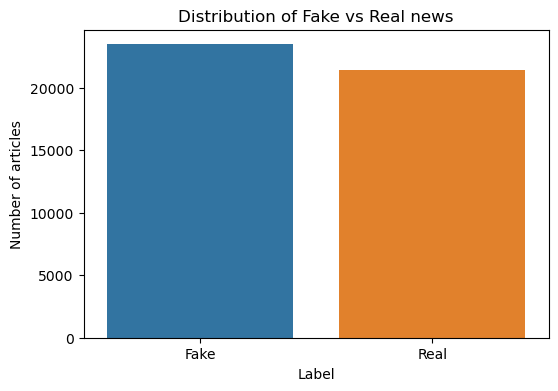

In [6]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_isot, x="label", hue="label", legend=False)
plt.title("Distribution of Fake vs Real news")
plt.xlabel("Label")
plt.ylabel("Number of articles")
plt.xticks(ticks=[0, 1], labels=["Fake", "Real"])
plt.show()

In [7]:
df_isot["label"].value_counts()

label
0    23481
1    21417
Name: count, dtype: int64

#### Article subject distribution by label

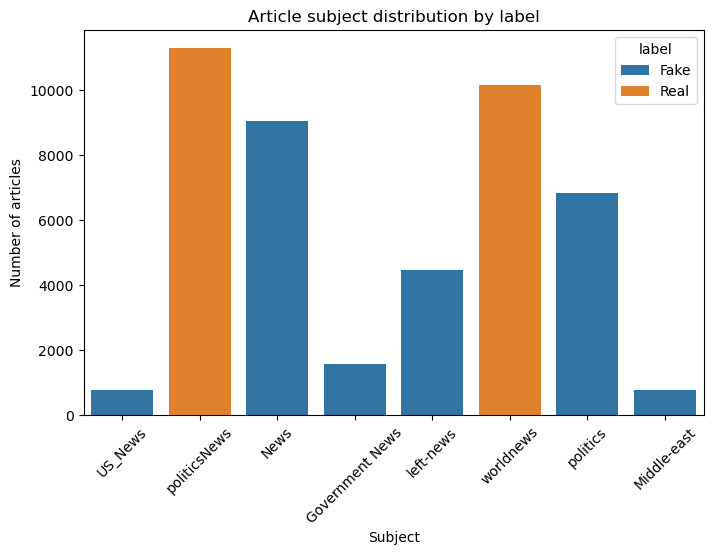

In [8]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df_isot, x="subject", hue="label")
plt.title("Article subject distribution by label")
plt.xlabel("Subject")
plt.ylabel("Number of articles")
plt.legend(title="label", labels=["Fake", "Real"])
plt.xticks(rotation=45)
plt.show()

#### Article length distribution (in number of words)

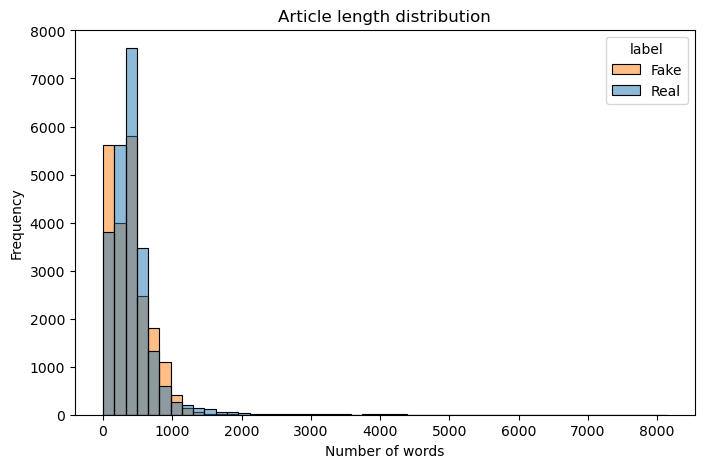

In [9]:
df_isot["article_length"] = df_isot["text"].fillna('').apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.histplot(data=df_isot, x="article_length", hue="label", bins=50)
plt.title("Article length distribution")
plt.legend(title="label", labels=["Fake", "Real"])
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

#### Title length distribution (in number of words)

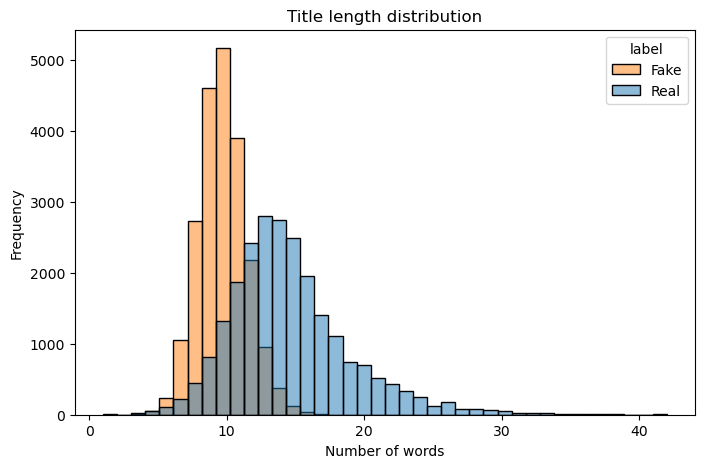

In [10]:
df_isot["title_length"] = df_isot["title"].fillna('').apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.histplot(data=df_isot, x="title_length", hue="label", bins=40)
plt.title("Title length distribution")
plt.legend(title="label", labels=["Fake", "Real"])
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

#### Word Cloud of text in Fake vs Real news

In [11]:
def clean_text(text):
    """
    Function to clean text and remove stopwords
    """
    text = re.sub(r"\W+", " ", text.lower())  # remove special caracters and lowercase
    stop_words = stopwords.words("english")
    filtered_tokens = [word for word in text.split() if word not in stop_words and len(word) > 2]
    return ' '.join(filtered_tokens)

In [12]:
df_isot["text_cleaned"] = df_isot["text"].apply(clean_text)

fake_text = " ".join(text for text in df_isot.loc[df_isot["label"] == 0, "text_cleaned"])
real_text = " ".join(text for text in df_isot.loc[df_isot["label"] == 1, "text_cleaned"])

# Word Clouds
fake_text_wc = WordCloud(background_color="white", width=800, height=400).generate(fake_text)
real_text_wc = WordCloud(background_color="white", width=800, height=400).generate(real_text)

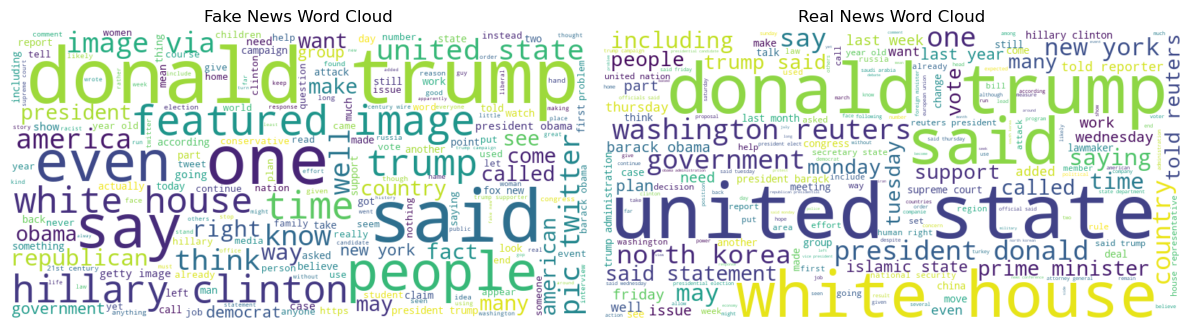

In [13]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(fake_text_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Fake News Word Cloud")

plt.subplot(1, 2, 2)
plt.imshow(real_text_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Real News Word Cloud")

plt.tight_layout()
plt.show()

## 3. Preprocessing 

In [14]:
def preprocessing_full(text):
    """
    Preprocessing function for models using Bag of Words and TF-IDF (with lemmatization).
    """
    # Lowercase
    text = text.lower()   
    # Remove URLs and Twitter handles
    text = re.sub(r"http\S+|www\S+|https\S+|@\w+", "", text) 
    # Remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)  
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    # Lemmatize and remove stopwords
    lemmatizer = WordNetLemmatizer()
    stop_words = stopwords.words("english")
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])    
    return text

In [15]:
def preprocessing_light(text):
    """
    Preprocessing function for models using Word2Vec and BERT (without lemmatization).
    """
    # Lowercase
    text = text.lower()   
    # Remove URLs and Twitter handles
    text = re.sub(r"http\S+|www\S+|https\S+|@\w+", "", text) 
    # Remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)  
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [16]:
# Apply full preprocessing
X_preprocessed_full = X.apply(preprocessing_full)

In [17]:
# Apply light preprocessing
X_preprocessed_light = X.apply(preprocessing_light)

## 4. Feature extraction

### 4.1. Bag of Words

In [18]:
def get_bow_features(X):
    """
    Extract Bag-of-Words features.
    """
    vectorizer = CountVectorizer(max_features=5000)
    X_bow = vectorizer.fit_transform(X)
    return X_bow, vectorizer

In [19]:
X_bow, bow_vectorizer = get_bow_features(X_preprocessed_full)

### 4.2. TF-IDF

In [20]:
def get_tfidf_features(X):
    """
    Extract TF-IDF features.
    """
    tfidf = TfidfVectorizer(max_features=5000)
    X_tfidf = tfidf.fit_transform(X)
    return X_tfidf, tfidf

In [21]:
X_tfidf, tfidf_vectorizer = get_tfidf_features(X_preprocessed_full)

### 4.3. Word2Vec

In [23]:
def load_word2vec_model(path="word2vec-google-news-300.kv"):
    """
    Load or download the Word2Vec Google News model.
    """
    if os.path.exists(path):
        model = KeyedVectors.load(path)
    else:
        print("Downloading Word2Vec model...")
        model = api.load("word2vec-google-news-300")
        model.save(path)
    print(f"Word2Vec loaded! Vocab size: {len(model.key_to_index)}")
    return model

In [24]:
def get_word2vec_embeddings(texts, model, save_path, vector_size=300):
    """
    Compute or load Word2Vec embeddings from preprocessed texts.
    """    
    if os.path.exists(save_path):
        print("Loading Word2Vec embeddings from cache.")
        with open(save_path, "rb") as f:
            return pickle.load(f)

    print("Computing Word2Vec embeddings...")
    
    def doc_to_vec(doc):
        tokens = doc.split()
        vectors = [model[word] for word in tokens if word in model.key_to_index]
        return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)

    embeddings = np.array([doc_to_vec(text) for text in texts])

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    with open(save_path, "wb") as f:
        pickle.dump(embeddings, f)
    
    return embeddings

In [25]:
# Load Word2Vec model
word2vec_model = load_word2vec_model()

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Word2Vec loaded! Vocab size: 3000000


In [29]:
# Extract or load embeddings
X_word2vec = get_word2vec_embeddings(X_preprocessed_light.tolist(), word2vec_model, "embeddings/isot/word2vec_embeddings.pkl")

Computing Word2Vec embeddings...


In [31]:
X_word2vec.shape

(44898, 300)

### 4.4. BERT

In [32]:
# Load tokenizer and model once
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)
bert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [33]:
def get_bert_embeddings_batch(texts, save_path, batch_size=32):
    """
    Compute BERT embeddings in batches or load from pickle if available.
    """
    if os.path.exists(save_path):
        print("Loading BERT embeddings from cache.")
        with open(save_path, 'rb') as f:
            return pickle.load(f)
        
    print("Computing BERT embeddings in batches...")
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy()) 
    X_bert = np.vstack(embeddings)

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    with open(save_path, 'wb') as f:
        pickle.dump(X_bert, f)
        
    return X_bert

In [34]:
X_bert = get_bert_embeddings_batch(X_preprocessed_light.tolist(), save_path="embeddings/isot/bert_embeddings.pkl")

Computing BERT embeddings in batches...


: 

### 4.5. Linguistic Cues

## 5. Model training